<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: SkimLit

Este projeto tem como objetivo reproduzir o artigo **PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts**. https://arxiv.org/abs/1710.06071

O resumo de artigos científicos de Medicina costumam ser blocos de texto de difícil interpretação imediata. Este artigo teve como propósito criar um modelo para classificação sequencial de sentenças, onde, uma vez apresentado um resumo, dividirá o texto em cinco categorias: Background, Conclusions, Methods, Objective e Results (Contexto, Conclusões, Métodos, Objetivo e Resultados), facilitando sua interpretação.

PubMed 200k RCT utiliza a arquitetura do modelo do artigo **Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**. https://arxiv.org/abs/1612.05251

In [74]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random, re

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dropout, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Setup

In [2]:
pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

### Constantes

In [88]:
SEMENTE = 2008193

COR = '#007f66'

DIRETORIO = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
# DIRETORIO = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'

# 1710.06071 - Tabela 2
LIMITE_DICIONARIO = 68000
# LIMITE_DICIONARIO = 331000

LIMITE_CARACTERES = 100

# 1612.05251 - Figura 1
LIMITE_INCORPORADOR = 300
LIMITE_INCORPORADOR_CARACTERES = 25
LIMITE_VETOR_TEXTO = 100

LOTE_TAMANHO = 32

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

FILTROS = 64
NUCLEO_TAMANHO = 5
PREENCHIMENTO = 'same'

PERDA = 'categorical_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 3

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-31 15:20:41--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5909 (5.8K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.77K  --.-KB/s    in 0s      

2023-01-31 15:20:41 (61.1 MB/s) - ‘funcoes.py’ saved [5909/5909]



In [5]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao

In [6]:
def preprocessar_texto(arquivo):
    """
    Retorna uma lista de dicionários com o conteúdo das linhas do arquivo informado.

    Cada dicionário contém o código do resumo, o total de linhas, o número, a classe e o texto da linha.
    {codigo, total, numero, classe, texto}
    """

    with open(arquivo, 'r') as a: linhas_arquivo = a.readlines()
    linhas = ''  # Linhas do texto
    saida = []   # Lista de dicionários

    for linha in linhas_arquivo:
        if linha.startswith('###'):            # Verifica se a linha inicia com '###'.
            codigo = re.sub('\D+', '', linha)  # Extrai o código do resumo.
            linhas = ''                        # Limpa as linhas de texto.
        
        elif linha.isspace():                       # Verifica se a linha é vazia.
            linhas_separadas = linhas.splitlines()  # Separa linhas de texto.

            for linha_numero, linha_completa in enumerate(linhas_separadas):  # Itera sobre cada uma das linhas de texto.
                linha_dados = {}                                              # Dicionário com os dados da linha.
                linha_conteudo = linha_completa.split('\t')                   # Separa classe e texto.

                linha_dados['codigo'] = codigo                    # Código do resumo.
                linha_dados['total'] = len(linhas_separadas)      # Total de linhas.
                linha_dados['numero'] = linha_numero              # Número da linha.
                linha_dados['classe'] = linha_conteudo[0]         # Classe da linha.
                linha_dados['texto'] = linha_conteudo[1].lower()  # Texto da linha, em caixa baixa.

                saida.append(linha_dados)  # Acrescenta o dicionário à lista.

        else:
            linhas += linha  # Acrescenta a linha atual às linhas de texto.

    return saida

## Dados

In [7]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.43 MiB/s, done.


### Pré-processamento

In [8]:
linhas_treino    = preprocessar_texto(f'{DIRETORIO}/train.txt')  # Dados de treino
linhas_validacao = preprocessar_texto(f'{DIRETORIO}/dev.txt')    # Dados de validação
linhas_teste     = preprocessar_texto(f'{DIRETORIO}/test.txt')   # Dados de teste

In [9]:
df_treino    = pd.DataFrame(linhas_treino)
df_validacao = pd.DataFrame(linhas_validacao)
df_teste     = pd.DataFrame(linhas_teste)

### Verificação

In [10]:
df_treino[:12]

,codigo,total,numero,classe,texto
0,24293578,12,0,OBJECTIVE,"to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) ."
1,24293578,12,1,METHODS,a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
2,24293578,12,2,METHODS,outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
3,24293578,12,3,METHODS,pain was assessed using the visual analog pain scale ( @-@ mm ) .
4,24293578,12,4,METHODS,"secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) ."
5,24293578,12,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured ."
6,24293578,12,6,RESULTS,"there was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , pga , and @mwd at @ weeks ."
7,24293578,12,7,RESULTS,"the mean difference between treatment arms ( @ % ci ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively ."
8,24293578,12,8,RESULTS,"further , there was a clinically relevant reduction in the serum levels of il-@ , il-@ , tnf - , and hscrp at @ weeks in the intervention group when compared to the placebo group ."
9,24293578,12,9,RESULTS,these differences remained significant at @ weeks .


In [11]:
df_treino['classe'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: classe, dtype: int64

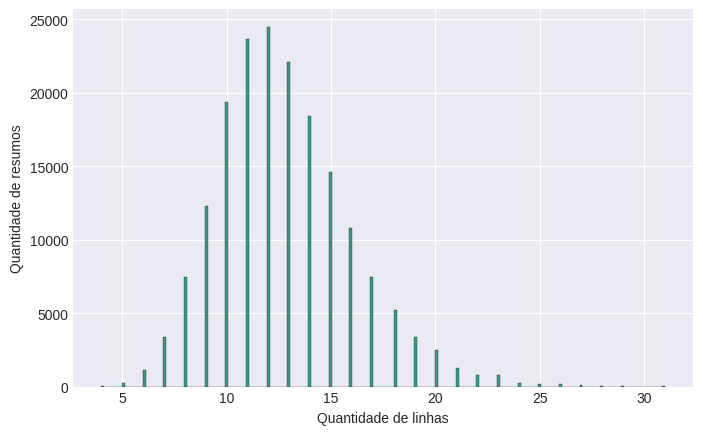

In [12]:
sns.histplot(data=df_treino, x='total', color=COR)

plt.xlabel('Quantidade de linhas')
plt.ylabel('Quantidade de resumos');

### Rótulos numéricos

#### One-hot

In [13]:
codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino    = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_validacao = codificador_onehot.transform(df_validacao['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_teste     = codificador_onehot.transform(df_teste['classe'].to_numpy().reshape(-1, 1))

In [14]:
rotulos_onehot_treino

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Inteiros

In [15]:
codificador_int = LabelEncoder()

rotulos_int_treino    = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_validacao = codificador_int.transform(df_validacao['classe'].to_numpy())
rotulos_int_teste     = codificador_int.transform(df_teste['classe'].to_numpy())

In [16]:
rotulos_int_treino

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
classes = codificador_int.classes_
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Modelos

In [18]:
avaliacoes = [None] * 7

### Modelo 0: TF-IDF Naive-Bayes

In [19]:
modelo_nome = 'modelo_0_tfidf_naive_bayes'

modelo = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', MultinomialNB())])

modelo.fit(df_treino['texto'], rotulos_int_treino)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
probabilidades = modelo.predict(df_validacao['texto'])

In [21]:
previsoes = np.zeros((probabilidades.size, probabilidades.max() + 1))
previsoes[np.arange(probabilidades.size), probabilidades] = 1

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.49      0.56      3449
 CONCLUSIONS       0.65      0.59      0.61      4582
     METHODS       0.72      0.87      0.79      9964
   OBJECTIVE       0.75      0.14      0.23      2376
     RESULTS       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



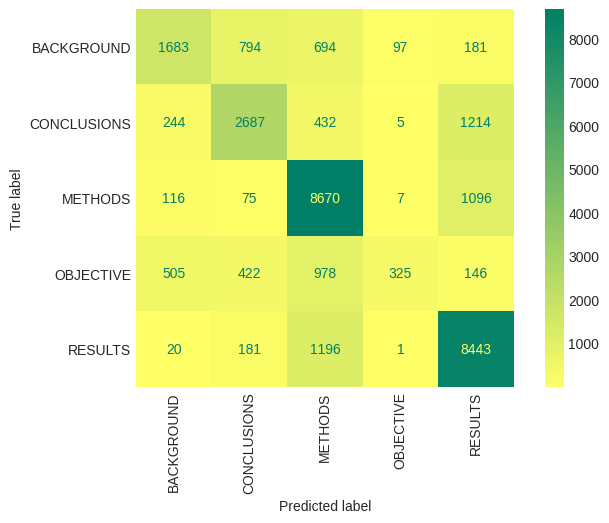

In [22]:
avaliacoes[0] = avaliar_modelo(rotulos_int_validacao, probabilidades, classes)

In [23]:
avaliacoes[0]

{'acuracia': 0.7218323844829869,
 'precisao': 0.7186466952323352,
 'revocacao': 0.7218323844829869,
 'pontuacao-f1': 0.6989250353450294}

### Preparação dos textos

In [24]:
palavras_por_texto    = [len(texto.split()) for texto in df_treino['texto']]
palavras_por_texto_95 = int(np.percentile(palavras_por_texto, 95))  # Quantidade máxima de palavras para 95% dos textos.

In [25]:
print(f"Média: {np.mean(palavras_por_texto)}")
print(f"Máximo: {np.max(palavras_por_texto)}")
print(f"95%: {palavras_por_texto_95}")

Média: 26.338269273494777
Máximo: 296
95%: 55


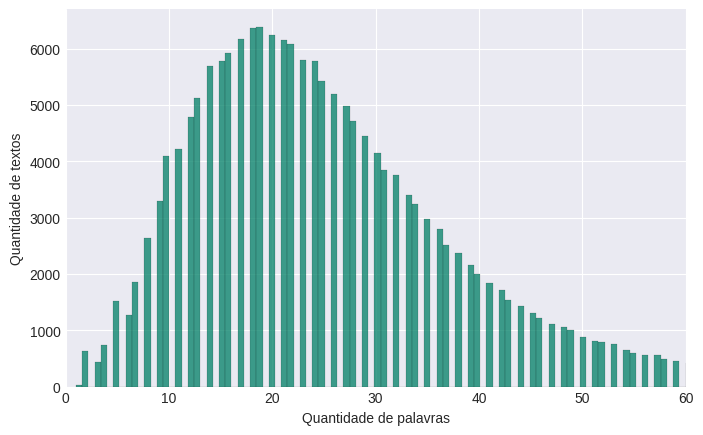

In [26]:
sns.histplot(x=palavras_por_texto, color=COR)

plt.xlim(0, 60)

plt.xlabel('Quantidade de palavras')
plt.ylabel('Quantidade de textos');

#### Vetorização

In [27]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,
                                output_mode='int',
                                output_sequence_length=palavras_por_texto_95,
                                name='vetorizador')

vetorizador.adapt(df_treino['texto'])

In [28]:
vetorizador.get_config()

{'name': 'vetorizador',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Vocabulário

In [29]:
vocabulario = vetorizador.get_vocabulary()

print(f"Tamanho do vocabulário: {len(vocabulario)}")
print(f"10 palavras mais comuns: {vocabulario[:10]}")
print(f"10 palavras menos comuns: {vocabulario[-10:]}")

Tamanho do vocabulário: 64841
10 palavras mais comuns: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 palavras menos comuns: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#### Incorporação

In [30]:
incorporador = Embedding(input_dim=len(vocabulario),
                         output_dim=LIMITE_INCORPORADOR,
                         mask_zero=True,
                         input_length=palavras_por_texto_95,
                         name='incorporador')

`mask_zero=True` otimiza o tratamento de preenchimento com valor zero nas camadas subsequentes e na função de perda.

Mais informações: https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work

In [31]:
incorporador.get_config()

{'name': 'incorporador',
 'trainable': True,
 'batch_input_shape': (None, 55),
 'dtype': 'float32',
 'input_dim': 64841,
 'output_dim': 300,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': True,
 'input_length': 55}

#### Verificação

In [32]:
texto_aleatorio = random.choice(df_treino['texto'])

vetorizado = vetorizador([texto_aleatorio])
incorporado = incorporador(vetorizado)

print(texto_aleatorio)
print()
print(f"Quantidade de palavras: {len(texto_aleatorio.split())}")
print(f"Formato vetorizado: {vetorizado.shape}")
print(f"Formato incorporado: {incorporado.shape}")
print()
print(vetorizado)
print()
print(incorporado)

within - and across-treatment group results at @ months and @ years were compared with original baseline values .

Quantidade de palavras: 19
Formato vetorizado: (1, 55)
Formato incorporado: (1, 55, 300)

tf.Tensor(
[[  219     3 64636    13   117    15    41     3    64     9    34     7
   2135    49   334     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)

tf.Tensor(
[[[-0.00919884 -0.03129194 -0.01420841 ...  0.00916583 -0.01472185
    0.0499461 ]
  [ 0.02707115  0.03974888 -0.04717281 ...  0.04857179  0.03588701
   -0.0392164 ]
  [ 0.01984382  0.03663618  0.00125592 ...  0.03860027 -0.04965117
   -0.01631231]
  ...
  [-0.02319256  0.04650941 -0.00204204 ...  0.00777267  0.04684791
    0.02932166]
  [-0.02319256  0.04650941 -0.00204204 ...  0.00777267  0.04684

#### Criação de datasets

Fusão dos dados e rótulos em datasets para ganho de performance.

Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance

In [33]:
# Datasets
dados_treino    = Dataset.from_tensor_slices((df_treino['texto'], rotulos_onehot_treino))
dados_validacao = Dataset.from_tensor_slices((df_validacao['texto'], rotulos_onehot_validacao))
dados_teste     = Dataset.from_tensor_slices((df_teste['texto'], rotulos_onehot_teste))

In [34]:
dados_treino

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [35]:
# Pré-buscas
dados_treino    = dados_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dados_validacao = dados_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dados_teste     = dados_teste.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [36]:
dados_treino

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Modelo 1: Conv1D com incorporação de palavras

In [37]:
modelo_nome = 'modelo_1_conv1d_inc_palavras'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(dados_treino,
                       epochs=ITERACOES,
                       validation_data=dados_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 91s 15ms/step - loss: 0.5966 - accuracy: 0.7840 - val_loss: 0.5294 - val_accuracy: 0.8104
Epoch 2/3
5627/5627 [==============================] - 82s 15ms/step - loss: 0.4333 - accuracy: 0.8485 - val_loss: 0.5292 - val_accuracy: 0.8128
Epoch 3/3
5627/5627 [==============================] - 82s 15ms/step - loss: 0.3389 - accuracy: 0.8852 - val_loss: 0.5841 - val_accuracy: 0.8059


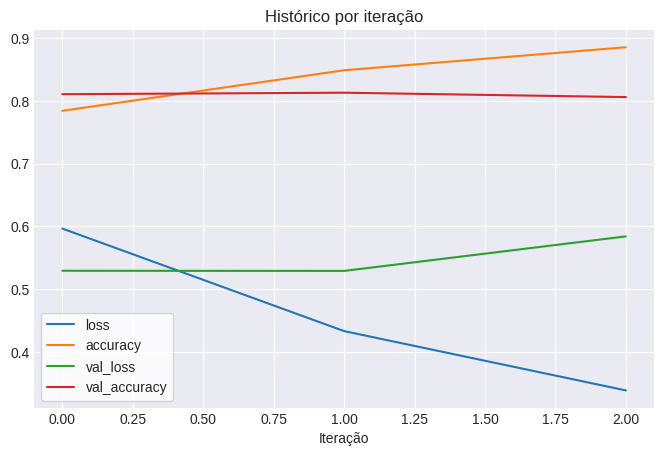

In [38]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.64      0.64      3449
 CONCLUSIONS       0.74      0.71      0.73      4582
     METHODS       0.88      0.88      0.88      9964
   OBJECTIVE       0.70      0.54      0.61      2376
     RESULTS       0.83      0.90      0.86      9841

    accuracy                           0.81     30212
   macro avg       0.76      0.73      0.74     30212
weighted avg       0.80      0.81      0.80     30212



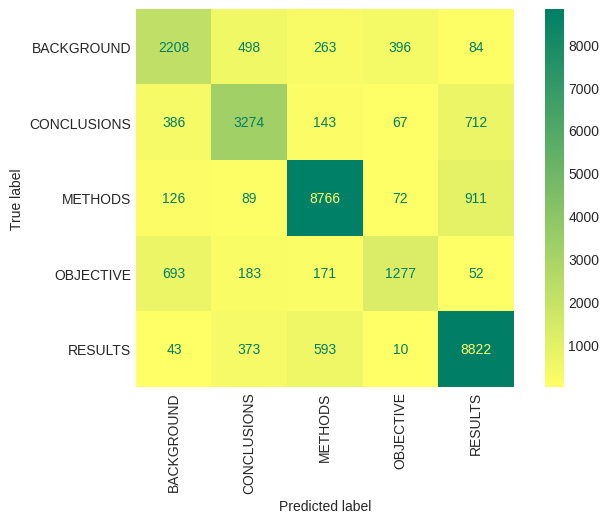

In [39]:
probabilidades = modelo.predict(dados_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[1]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [40]:
avaliacoes[1]

{'acuracia': 0.8058718390043691,
 'precisao': 0.8030199344862403,
 'revocacao': 0.8058718390043691,
 'pontuacao-f1': 0.8031901013204575}

### Modelo 2: TFHub USE

In [41]:
modelo_nome = 'modelo_2_use'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada')  # shape=[] para entradas de tamanho variável

incorporador_use = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='incorporador_use')(entradas)

camadas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu')(incorporador_use)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(dados_treino,
                       epochs=ITERACOES,
                       validation_data=dados_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 77s 13ms/step - loss: 0.7038 - accuracy: 0.7310 - val_loss: 0.6340 - val_accuracy: 0.7580
Epoch 2/3
5627/5627 [==============================] - 72s 13ms/step - loss: 0.6108 - accuracy: 0.7686 - val_loss: 0.6032 - val_accuracy: 0.7698
Epoch 3/3
5627/5627 [==============================] - 73s 13ms/step - loss: 0.5728 - accuracy: 0.7836 - val_loss: 0.5919 - val_accuracy: 0.7751


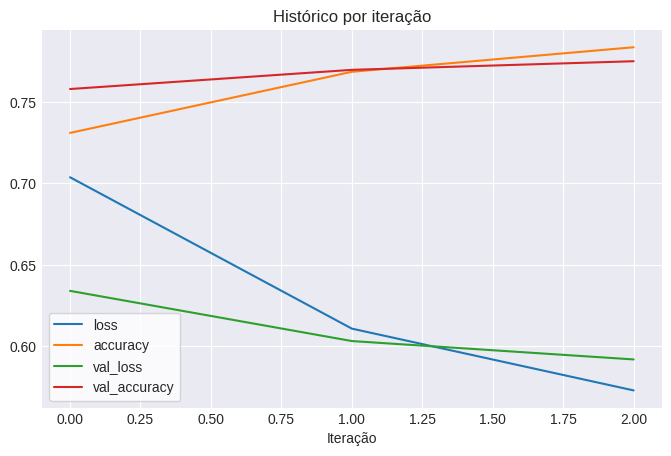

In [42]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 10s 10ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.63      0.62      3449
 CONCLUSIONS       0.69      0.67      0.68      4582
     METHODS       0.85      0.85      0.85      9964
   OBJECTIVE       0.75      0.45      0.56      2376
     RESULTS       0.80      0.88      0.84      9841

    accuracy                           0.78     30212
   macro avg       0.74      0.70      0.71     30212
weighted avg       0.77      0.78      0.77     30212



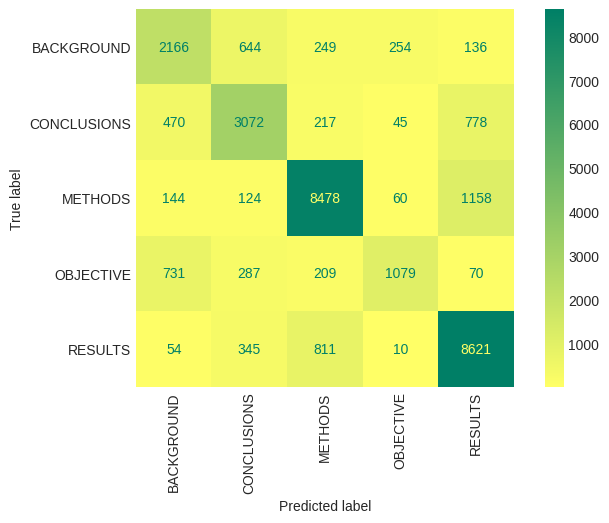

In [43]:
probabilidades = modelo.predict(dados_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[2]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [44]:
avaliacoes[2]

{'acuracia': 0.7750562690321726,
 'precisao': 0.7736690963937736,
 'revocacao': 0.7750562690321726,
 'pontuacao-f1': 0.7710039857185084}

### Preparação dos caracteres

In [45]:
caracteres_por_texto    = [len(texto) for texto in df_treino['texto']]
caracteres_por_texto_95 = int(np.percentile(caracteres_por_texto, 95))  # Quantidade máxima de caracteres para 95% dos textos.

In [46]:
print(f"Média: {np.mean(caracteres_por_texto)}")
print(f"Máximo: {np.max(caracteres_por_texto)}")
print(f"95%: {caracteres_por_texto_95}")

Média: 149.3662574983337
Máximo: 1386
95%: 290


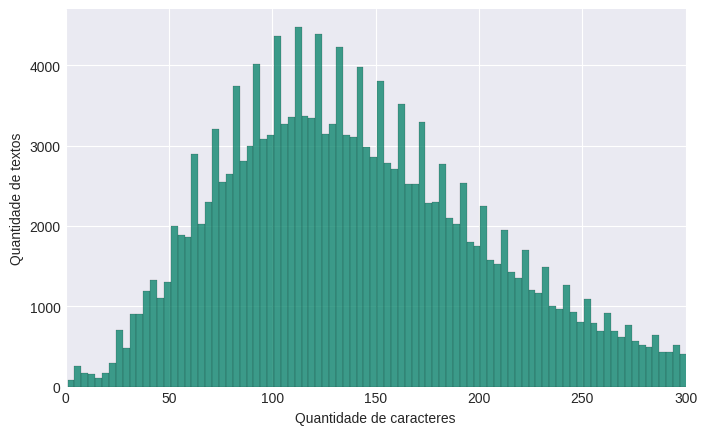

In [47]:
sns.histplot(x=caracteres_por_texto, color=COR)

plt.xlim(0, 300)

plt.xlabel('Quantidade de caracteres')
plt.ylabel('Quantidade de textos');

#### Listas de caracteres

In [48]:
lista_caracteres_treino    = [" ".join(list(texto)) for texto in df_treino['texto']]
lista_caracteres_validacao = [" ".join(list(texto)) for texto in df_validacao['texto']]
lista_caracteres_teste     = [" ".join(list(texto)) for texto in df_teste['texto']]

#### Vetorização

In [49]:
vetorizador_caracteres = TextVectorization(max_tokens=LIMITE_CARACTERES,
                                           output_mode='int',
                                           output_sequence_length=caracteres_por_texto_95,
                                           name='vetorizador_caracteres')

vetorizador_caracteres.adapt(lista_caracteres_treino)

In [50]:
vetorizador_caracteres.get_config()

{'name': 'vetorizador_caracteres',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 100,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Vocabulário

In [51]:
vocabulario_caracteres = vetorizador_caracteres.get_vocabulary()

print(f"Tamanho do vocabulário: {len(vocabulario_caracteres)}")
print(f"10 caracteres mais comuns: {vocabulario_caracteres[:10]}")
print(f"10 caracteres menos comuns: {vocabulario_caracteres[-10:]}")

Tamanho do vocabulário: 28
10 caracteres mais comuns: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
10 caracteres menos comuns: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


#### Incorporação

In [52]:
incorporador_caracteres = Embedding(input_dim=len(vocabulario_caracteres),
                                    output_dim=LIMITE_INCORPORADOR_CARACTERES,
                                    mask_zero=True,
                                    input_length=caracteres_por_texto_95,
                                    name='incorporador_caracteres')

In [53]:
incorporador_caracteres.get_config()

{'name': 'incorporador_caracteres',
 'trainable': True,
 'batch_input_shape': (None, 290),
 'dtype': 'float32',
 'input_dim': 28,
 'output_dim': 25,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': True,
 'input_length': 290}

#### Verificação

In [54]:
texto_aleatorio = random.choice(lista_caracteres_treino)

vetorizado = vetorizador_caracteres([texto_aleatorio])
incorporado = incorporador_caracteres(vetorizado)

print(texto_aleatorio)
print()
print(f"Quantidade de caracteres: {len(texto_aleatorio.split())}")
print(f"Formato vetorizado: {vetorizado.shape}")
print(f"Formato incorporado: {incorporado.shape}")
print()
print(vetorizado)
print()
print(incorporado)

t w o   h u n d r e d   s e v e n t e e n   (   @   %   )   w o m e n   c o m p l e t e d   a n   e n d - o f - s t u d y   e v a l u a t i o n   .

Quantidade de caracteres: 62
Formato vetorizado: (1, 290)
Formato incorporado: (1, 290, 25)

tf.Tensor(
[[ 3 20  7 13 16  6 10  8  2 10  9  2 21  2  6  3  2  2  6 20  7 15  2  6
  11  7 15 14 12  2  3  2 10  5  6  2  6 10  7 17  9  3 16 10 19  2 21  5
  12 16  5  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

#### Criação de datasets

In [55]:
# Datasets
caracteres_treino    = Dataset.from_tensor_slices((lista_caracteres_treino, rotulos_onehot_treino))
caracteres_validacao = Dataset.from_tensor_slices((lista_caracteres_validacao, rotulos_onehot_validacao))
caracteres_teste     = Dataset.from_tensor_slices((lista_caracteres_teste, rotulos_onehot_teste))

In [56]:
caracteres_treino

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [57]:
# Pré-buscas
caracteres_treino    = caracteres_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
caracteres_validacao = caracteres_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
caracteres_teste     = caracteres_teste.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [58]:
caracteres_treino

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Modelo 3: Conv1D com incorporação de caracteres

In [59]:
modelo_nome = 'modelo_3_conv1d_inc_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(caracteres_treino,
                       epochs=ITERACOES,
                       validation_data=caracteres_validacao,
                       verbose=1)

Epoch 1/6
5627/5627 [==============================] - 31s 5ms/step - loss: 0.8878 - accuracy: 0.6539 - val_loss: 0.7772 - val_accuracy: 0.7004
Epoch 2/6
5627/5627 [==============================] - 39s 7ms/step - loss: 0.7478 - accuracy: 0.7142 - val_loss: 0.7280 - val_accuracy: 0.7225
Epoch 3/6
5627/5627 [==============================] - 33s 6ms/step - loss: 0.7139 - accuracy: 0.7297 - val_loss: 0.7098 - val_accuracy: 0.7305
Epoch 4/6
5627/5627 [==============================] - 31s 6ms/step - loss: 0.6951 - accuracy: 0.7377 - val_loss: 0.6991 - val_accuracy: 0.7361
Epoch 5/6
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6827 - accuracy: 0.7424 - val_loss: 0.6907 - val_accuracy: 0.7403
Epoch 6/6
5627/5627 [==============================] - 34s 6ms/step - loss: 0.6739 - accuracy: 0.7465 - val_loss: 0.6876 - val_accuracy: 0.7403


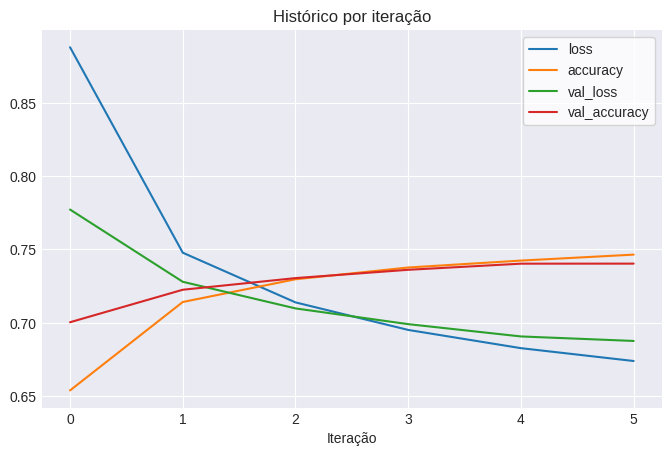

In [60]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.58      0.54      0.56      3449
 CONCLUSIONS       0.67      0.55      0.61      4582
     METHODS       0.83      0.82      0.82      9964
   OBJECTIVE       0.64      0.46      0.54      2376
     RESULTS       0.74      0.89      0.81      9841

    accuracy                           0.74     30212
   macro avg       0.69      0.65      0.67     30212
weighted avg       0.74      0.74      0.73     30212



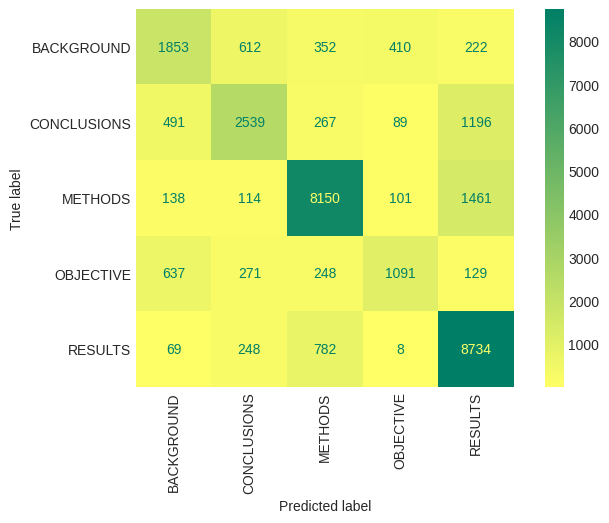

In [61]:
probabilidades = modelo.predict(caracteres_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[3]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [62]:
avaliacoes[3]

{'acuracia': 0.7403349662385807,
 'precisao': 0.7352078675116753,
 'revocacao': 0.7403349662385807,
 'pontuacao-f1': 0.7335520072037081}

### Criação de datasets híbridos

In [63]:
# Dataset treino
dados_hibridos_treino_textos  = Dataset.from_tensor_slices((df_treino['texto'], lista_caracteres_treino))
dados_hibridos_treino_rotulos = Dataset.from_tensor_slices(rotulos_onehot_treino)
dados_hibridos_treino         = Dataset.zip((dados_hibridos_treino_textos, dados_hibridos_treino_rotulos))

In [64]:
dados_hibridos_treino

<ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [65]:
# Dataset validação
dados_hibridos_validacao_textos  = Dataset.from_tensor_slices((df_validacao['texto'], lista_caracteres_validacao))
dados_hibridos_validacao_rotulos = Dataset.from_tensor_slices(rotulos_onehot_validacao)
dados_hibridos_validacao         = Dataset.zip((dados_hibridos_validacao_textos, dados_hibridos_validacao_rotulos))

In [66]:
dados_hibridos_validacao

<ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [67]:
# Pré-buscas
dados_hibridos_treino    = dados_hibridos_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dados_hibridos_validacao = dados_hibridos_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [68]:
dados_hibridos_treino, dados_hibridos_validacao

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Modelo 4: Camada de incorporação híbrida

Incorporação híbrida é a fusão de duas ou mais incorporações diferentes, neste caso incorporações de palavras e caracteres. Para isso temos os seguintes passos:

1. Criar um modelo com incorporação de palavras (Universal Sentence Encoder, como no Modelo 2);
2. Criar um modelo com incorporação de caracteres (similar ao Modelo 3);
3. Combinar os modelos com `tf.keras.layers.concatenate`;
4. Construir uma série de camadas de saída, similar ao descrito na Figura 1 e Seção 4.2 do artigo 1612.05251;
5. Construir um modelo que utilize os itens acima como entrada e retorne as probabilidades de rótulo sequenciais.

#### Criação do modelo com incorporação de palavras

In [81]:
modelo_nome = 'modelo_incorporacao_palavras'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

incorporador_use = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='incorporador_use')(entradas)

saidas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu_palavras')(incorporador_use)

modelo_incorporacao_palavras = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

#### Criação do modelo com incorporação de caracteres

In [82]:
modelo_nome = 'modelo_incorporacao_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_caracteres')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

# Camada Bidirectional LSTM (1612.05251 - Figura 1)
saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR_CARACTERES, activation=ATIVACAO_RNN), name='camada_bi_lstm_caracteres')(camadas)

modelo_incorporacao_caracteres = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

#### Combinação dos modelos

In [83]:
combinacao = Concatenate(name="camada_combinacao")([modelo_incorporacao_palavras.output,
                                                    modelo_incorporacao_caracteres.output])

#### Construção das camadas de saída

In [89]:
# Taxa de abandono de 50% (1612.05251 - Seção 4.2)
abandonos = Dropout(rate=0.5, name='camada_abandonos_combinacao')(combinacao)
abandonos = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_relu')(abandonos)
abandonos = Dropout(rate=0.5, name='camada_abandonos_final')(abandonos)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos)

#### Construção do modelo com incorporação híbrida

In [90]:
modelo_nome = 'modelo_4_incorporacao_hibrida'

modelo = Model(inputs=[modelo_incorporacao_palavras.input, modelo_incorporacao_caracteres.input],
               outputs=saidas,
               name=modelo_nome)

#### Verificação do modelo

In [91]:
modelo.summary()

Model: "modelo_4_incorporacao_hibrida"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 vetorizador_caracteres (TextVe  (None, 290)         0           ['camada_entrada_caracteres[0][0]
 ctorization)                                                    ']   

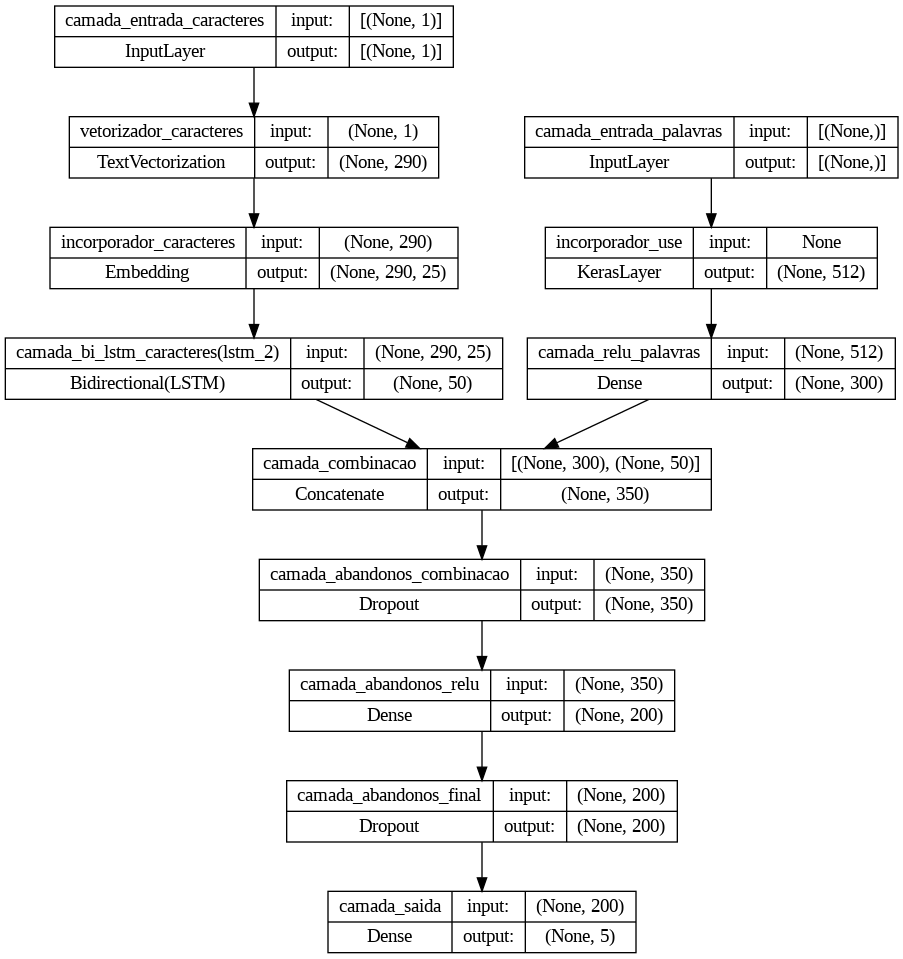

In [92]:
plot_model(modelo, show_shapes=True)

#### Finalização do modelo

In [93]:
# O artigo 1612.05251 informa que o otimizador utilizado foi stochastic gradient descent (SGD).
# Utilizaremos o otimizador Adam para comparações com os modelos anteriores.

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(dados_hibridos_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 311s 54ms/step - loss: 0.7235 - accuracy: 0.7240 - val_loss: 0.6111 - val_accuracy: 0.7680
Epoch 2/3
5627/5627 [==============================] - 297s 53ms/step - loss: 0.6439 - accuracy: 0.7574 - val_loss: 0.5756 - val_accuracy: 0.7824
Epoch 3/3
5627/5627 [==============================] - 292s 52ms/step - loss: 0.6155 - accuracy: 0.7680 - val_loss: 0.5611 - val_accuracy: 0.7889


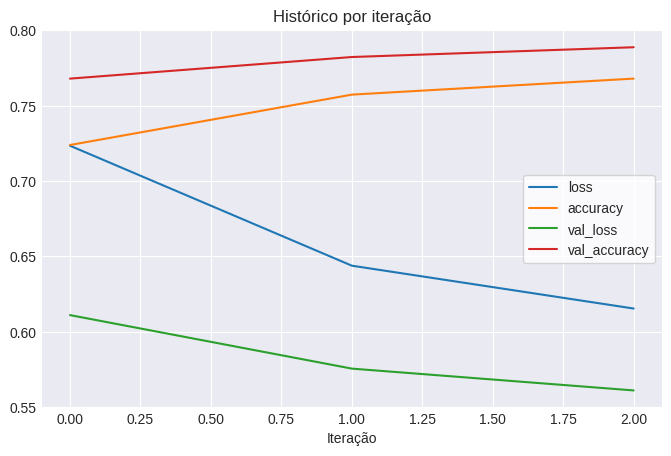

In [94]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 25s 24ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.62      0.62      3449
 CONCLUSIONS       0.70      0.70      0.70      4582
     METHODS       0.86      0.87      0.86      9964
   OBJECTIVE       0.77      0.52      0.62      2376
     RESULTS       0.82      0.88      0.85      9841

    accuracy                           0.79     30212
   macro avg       0.75      0.72      0.73     30212
weighted avg       0.79      0.79      0.79     30212



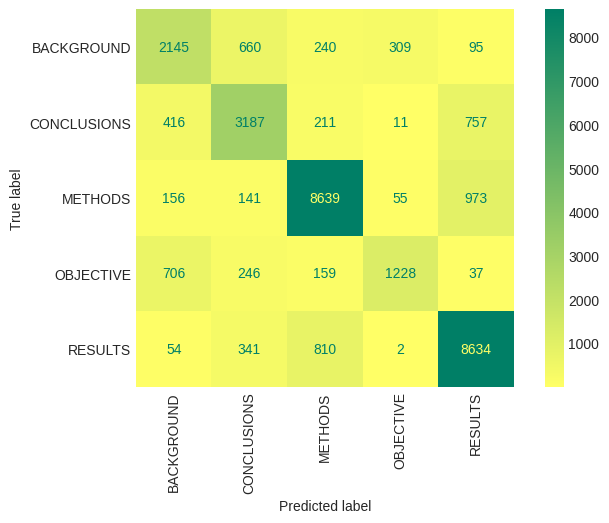

In [95]:
probabilidades = modelo.predict(dados_hibridos_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[4]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [96]:
avaliacoes[4]

{'acuracia': 0.788858731629816,
 'precisao': 0.7874391074024741,
 'revocacao': 0.788858731629816,
 'pontuacao-f1': 0.7859633682559055}